# 1. Quá trình dự báo trên mô hình LR

## Thêm thư viện

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from statsmodels.tsa.stattools import adfuller


from sklearn.metrics import mean_squared_error
from sklearn.utils import column_or_1d
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.models import load_model

## Nạp dữ liệu từ file csv

In [2]:
df = pd.read_csv('btc.csv', parse_dates=True,
                 index_col=0).drop(columns=['Close', 'High', 'Low', 'Volume', 'Currency'])
df

,Open
Date,
2020-06-01,0.94545
2020-06-02,1.01907
2020-06-03,0.95270
2020-06-04,0.96672
2020-06-05,0.97940
...,...
2022-05-28,2.86201
2022-05-29,2.90271
2022-05-30,2.94652


In [3]:
df['Timestamp'] = pd.to_datetime(df.index).astype(np.int64) / 10**9
df_index = df.index
df_open = df['Open'].values.reshape(-1, 1)
df.head()

df

,Open,Timestamp
Date,,
2020-06-01,0.94545,1.590970e+09
2020-06-02,1.01907,1.591056e+09
2020-06-03,0.95270,1.591142e+09
2020-06-04,0.96672,1.591229e+09
2020-06-05,0.97940,1.591315e+09
...,...,...
2022-05-28,2.86201,1.653696e+09
2022-05-29,2.90271,1.653782e+09
2022-05-30,2.94652,1.653869e+09


## Chuẩn hóa dữ liệu

In [4]:
LR_sc = StandardScaler()

df_scaled = df.copy()
df_scaled['Open'] = LR_sc.fit_transform(df_open)
df_scaled

,Open,Timestamp
Date,,
2020-06-01,-1.566754,1.590970e+09
2020-06-02,-1.522736,1.591056e+09
2020-06-03,-1.562419,1.591142e+09
2020-06-04,-1.554036,1.591229e+09
2020-06-05,-1.546455,1.591315e+09
...,...,...
2022-05-28,-0.420844,1.653696e+09
2022-05-29,-0.396509,1.653782e+09
2022-05-30,-0.370315,1.653869e+09


## Vẽ đồ thị

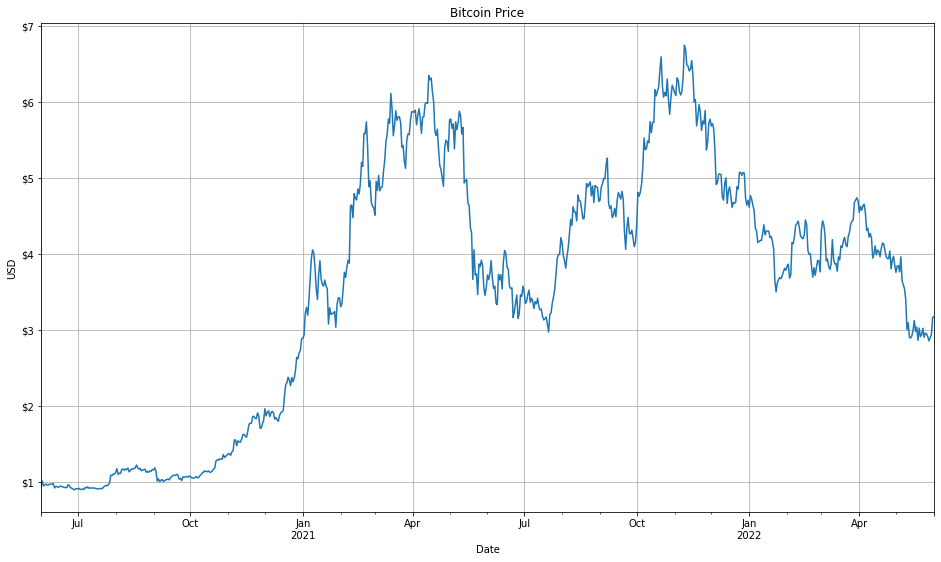

In [5]:
# Thư viện vẽ đồ thị
formatter = ticker.StrMethodFormatter('${x:,.0f}')

title = 'Bitcoin Price'
ylabel = 'USD'
xlabel = 'Date'

ax = df['Open'].plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [6]:
df

,Open,Timestamp
Date,,
2020-06-01,0.94545,1.590970e+09
2020-06-02,1.01907,1.591056e+09
2020-06-03,0.95270,1.591142e+09
2020-06-04,0.96672,1.591229e+09
2020-06-05,0.97940,1.591315e+09
...,...,...
2022-05-28,2.86201,1.653696e+09
2022-05-29,2.90271,1.653782e+09
2022-05-30,2.94652,1.653869e+09


## Chuẩn hóa dữ liệu

In [7]:
X_sc = StandardScaler()
y_sc = StandardScaler()

X = df.iloc[:, 1].values.reshape(-1, 1)
y = df.iloc[:, 0].values.reshape(-1, 1)


X_scaled = X_sc.fit_transform(X)
y_scaled = y_sc.fit_transform(y)


df_scaled = pd.DataFrame(index=df_index)
df_scaled['Timestamp'] = X_scaled
df_scaled['Open'] = y_scaled
df_scaled.head()


,Timestamp,Open
Date,,
2020-06-01,-1.729683,-1.566754
2020-06-02,-1.724944,-1.522736
2020-06-03,-1.720205,-1.562419
2020-06-04,-1.715466,-1.554036
2020-06-05,-1.710728,-1.546455


## Chia tập dữ liệu

In [8]:
interrupt = int(len(df_scaled) * .8)
interrupt


584

In [9]:
train_data, test_data = df_scaled[:interrupt], df_scaled[interrupt:]
index_test = df_scaled.index[interrupt:]
print(train_data.shape)
print(test_data.shape)


(584, 2)
(147, 2)


In [10]:
train_data.tail()

,Timestamp,Open
Date,,
2022-01-01,1.014116,0.631304
2022-01-02,1.018854,0.722257
2022-01-03,1.023593,0.695662
2022-01-04,1.028332,0.644350
2022-01-05,1.033071,0.608321


In [11]:
test_data.head()

,Timestamp,Open
Date,,
2022-01-06,1.037810,0.464735
2022-01-07,1.042549,0.444783
2022-01-08,1.047288,0.352312
2022-01-09,1.052026,0.360079
2022-01-10,1.056765,0.370106


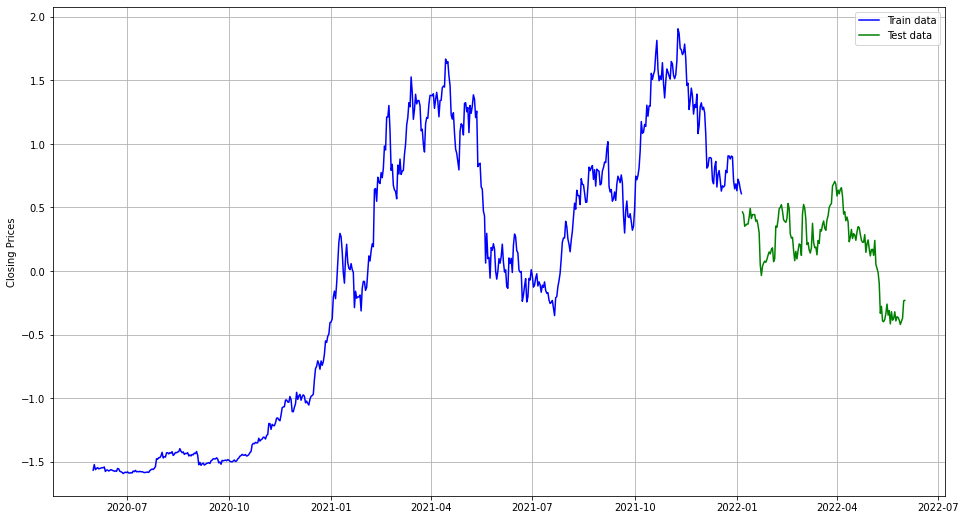

In [12]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(train_data['Open'], 'blue', label='Train data')
plt.plot(test_data['Open'], 'green', label='Test data')
plt.legend()




*   Gọi biến X <- Timestamp
*   Gọi biến y <- Open




In [13]:
X_train = train_data['Timestamp'].values.reshape(-1, 1)
y_train = train_data['Open'].values.reshape(-1, 1)

X_test = test_data['Timestamp'].values.reshape(-1, 1)
y_test = test_data['Open'].values.reshape(-1, 1)


In [14]:
from sklearn.linear_model import LinearRegression
LR_model = LinearRegression()
LR_model.fit(X_train,y_train)
pred = LR_model.predict(X_test)

In [15]:
inv_pred = y_sc.inverse_transform(pred.reshape(-1, 1))
inv_test = y_sc.inverse_transform(y_test.reshape(-1, 1))

## Vẽ đồ thị cho tập test và kết quả dự đoán

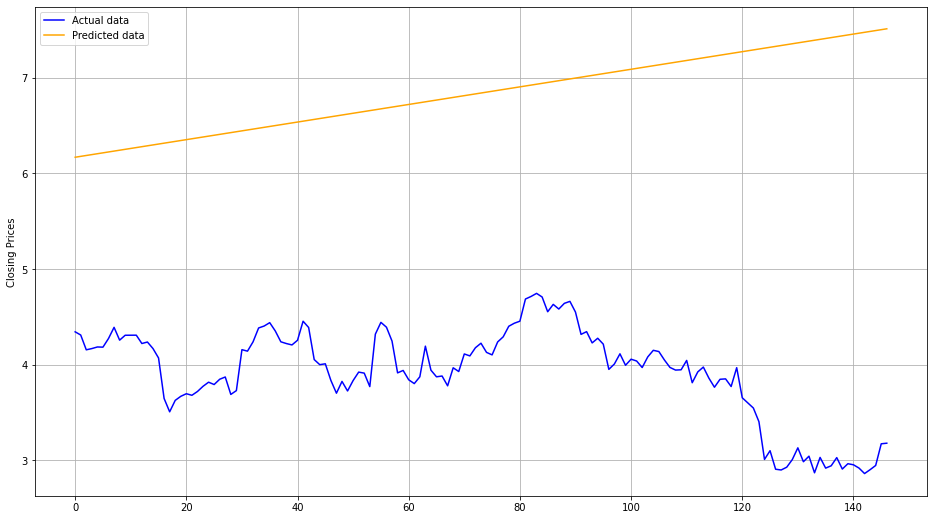

In [16]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.ylabel('Closing Prices')
plt.plot(column_or_1d(inv_test), 'blue', label='Actual data')
plt.plot(column_or_1d(inv_pred), 'orange', label='Predicted data')
plt.legend()


In [17]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(inv_test, inv_pred)
mape = mean_absolute_percentage_error(inv_test, inv_pred)
mse = mean_squared_error(inv_test, inv_pred)
rmse = np.sqrt(mse)
r2 = r2_score(inv_test, inv_pred)
print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape*100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 2.93
MAPE: 78.60%
MSE: 9.14
RMSE: 3.02
R2: -38.47


## Tạo một DataFrame là 'df_pred' để lưu kết quả dự đoán trên mô hình LR

In [18]:
df_pred = pd.DataFrame(columns=['Actual', 'Pred', 'Error'], index=index_test)
df_pred['Actual'] = column_or_1d(inv_test)
df_pred['Pred'] = column_or_1d(inv_pred)
df_pred['Error'] = df_pred['Actual'] - df_pred['Pred']
df_pred

,Actual,Pred,Error
Date,,,
2022-01-06,4.34316,6.167499,-1.824339
2022-01-07,4.30979,6.176692,-1.866902
2022-01-08,4.15513,6.185886,-2.030756
2022-01-09,4.16812,6.195080,-2.026960
2022-01-10,4.18489,6.204273,-2.019383
...,...,...,...
2022-05-28,2.86201,7.472990,-4.610980
2022-05-29,2.90271,7.482184,-4.579474
2022-05-30,2.94652,7.491378,-4.544858


# 2. Quá trình dự đoán trên mô hình LSTM

## Tạo thêm một DataFrame để tiến hành dự đoán sai số trên mô hình LSTM

In [19]:
df_lstm = df_pred.copy()
df_lstm

,Actual,Pred,Error
Date,,,
2022-01-06,4.34316,6.167499,-1.824339
2022-01-07,4.30979,6.176692,-1.866902
2022-01-08,4.15513,6.185886,-2.030756
2022-01-09,4.16812,6.195080,-2.026960
2022-01-10,4.18489,6.204273,-2.019383
...,...,...,...
2022-05-28,2.86201,7.472990,-4.610980
2022-05-29,2.90271,7.482184,-4.579474
2022-05-30,2.94652,7.491378,-4.544858


## Vẽ đồ thị thể hiện sai số

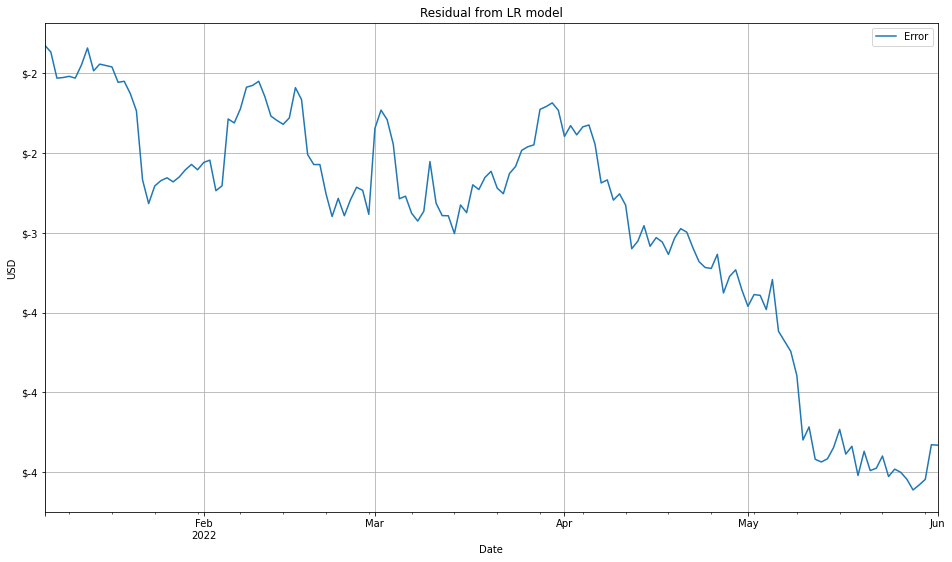

In [20]:
formatter = ticker.StrMethodFormatter('${x:,.0f}')

error = df_lstm[['Error']]
title = 'Residual from LR model'
ylabel = 'USD'
xlabel = 'Date'

ax = error.plot(figsize=(16, 9), title=title)
ax.autoscale(axis='x', tight=True)
ax.set(xlabel=xlabel, ylabel=ylabel)
ax.yaxis.set_major_formatter(formatter)
ax.grid(True)

In [21]:
error = np.array(error)
error

array([[-1.82433884],
       [-1.86690244],
       [-2.03075605],
       [-2.02695965],
       [-2.01938325],
       [-2.03055685],
       [-1.94916046],
       [-1.84185406],
       [-1.98482766],
       [-1.94288127],
       [-1.95151487],
       [-1.96057847],
       [-2.05683207],
       [-2.05048568],
       [-2.12784928],
       [-2.23559288],
       [-2.66782648],
       [-2.81650009],
       [-2.70612369],
       [-2.67304729],
       [-2.6551409 ],
       [-2.6805545 ],
       [-2.6501981 ],
       [-2.6053017 ],
       [-2.57139531],
       [-2.60495891],
       [-2.55897251],
       [-2.54460611],
       [-2.73589972],
       [-2.70533332],
       [-2.28665692],
       [-2.31131052],
       [-2.22317413],
       [-2.08749773],
       [-2.07626133],
       [-2.05038494],
       [-2.14653854],
       [-2.26882214],
       [-2.29630574],
       [-2.31993935],
       [-2.28021295],
       [-2.09034655],
       [-2.16508015],
       [-2.50957376],
       [-2.57200736],
       [-2

In [22]:
look_back = 3
x_total, y_total = [], []
for i in range(look_back, len(error)):
	x_total.append(error[i-look_back:i])
	y_total.append(error[i])
x_train = np.array(x_total[:len(error)])
y_train = np.array(y_total[:len(error)])

print("x_train",x_train.shape)
print("y_train",y_train.shape)


x_train (144, 3, 1)
y_train (144, 1)


In [23]:
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(x_train, y_train, epochs=300, verbose=1)
model.save("bitcoin.h5")

Epoch 1/300
5/5 [==============================] - 3s 6ms/step - loss: 9.1641
Epoch 2/300
5/5 [==============================] - 0s 5ms/step - loss: 8.7259
Epoch 3/300
5/5 [==============================] - 0s 6ms/step - loss: 8.3138
Epoch 4/300
5/5 [==============================] - 0s 6ms/step - loss: 7.8545
Epoch 5/300
5/5 [==============================] - 0s 6ms/step - loss: 7.2771
Epoch 6/300
5/5 [==============================] - 0s 7ms/step - loss: 6.4288
Epoch 7/300
5/5 [==============================] - 0s 6ms/step - loss: 5.1912
Epoch 8/300
5/5 [==============================] - 0s 8ms/step - loss: 3.4461
Epoch 9/300
5/5 [==============================] - 0s 6ms/step - loss: 1.3418
Epoch 10/300
5/5 [==============================] - 0s 6ms/step - loss: 0.6920
Epoch 11/300
5/5 [==============================] - 0s 6ms/step - loss: 1.0059
Epoch 12/300
5/5 [==============================] - 0s 6ms/step - loss: 0.4590
Epoch 13/300
5/5 [==============================] - 0s 6ms/st

In [24]:
model = load_model("bitcoin.h5")
error_pred = model.predict(x_train)
error_pred

array([[-1.9462645],
       [-2.015124 ],
       [-2.0470374],
       [-2.0471578],
       [-2.0234003],
       [-1.9614505],
       [-1.9513047],
       [-1.965524 ],
       [-1.9855361],
       [-1.9821715],
       [-2.0183513],
       [-2.0540998],
       [-2.0963488],
       [-2.1603727],
       [-2.3671021],
       [-2.6203852],
       [-2.7139738],
       [-2.6750162],
       [-2.639463 ],
       [-2.6370335],
       [-2.6334271],
       [-2.6073027],
       [-2.5715508],
       [-2.5636544],
       [-2.5550654],
       [-2.5358493],
       [-2.5948324],
       [-2.6609342],
       [-2.5166955],
       [-2.355045 ],
       [-2.269815 ],
       [-2.1932468],
       [-2.123241 ],
       [-2.0861316],
       [-2.1061642],
       [-2.178722 ],
       [-2.2536278],
       [-2.2947261],
       [-2.2948036],
       [-2.2173853],
       [-2.1639745],
       [-2.2761865],
       [-2.450734 ],
       [-2.5369062],
       [-2.6155956],
       [-2.7479   ],
       [-2.7915564],
       [-2.80

In [25]:
df_lstm

,Actual,Pred,Error
Date,,,
2022-01-06,4.34316,6.167499,-1.824339
2022-01-07,4.30979,6.176692,-1.866902
2022-01-08,4.15513,6.185886,-2.030756
2022-01-09,4.16812,6.195080,-2.026960
2022-01-10,4.18489,6.204273,-2.019383
...,...,...,...
2022-05-28,2.86201,7.472990,-4.610980
2022-05-29,2.90271,7.482184,-4.579474
2022-05-30,2.94652,7.491378,-4.544858


In [26]:
df_lstm = df_lstm.copy().head(len(error_pred))
df_lstm['Error Prediction'] = error_pred
df_lstm

,Actual,Pred,Error,Error Prediction
Date,,,,
2022-01-06,4.34316,6.167499,-1.824339,-1.946265
2022-01-07,4.30979,6.176692,-1.866902,-2.015124
2022-01-08,4.15513,6.185886,-2.030756,-2.047037
2022-01-09,4.16812,6.195080,-2.026960,-2.047158
2022-01-10,4.18489,6.204273,-2.019383,-2.023400
...,...,...,...,...
2022-05-25,2.96487,7.445410,-4.480540,-4.392435
2022-05-26,2.95379,7.454603,-4.500813,-4.446452
2022-05-27,2.91940,7.463797,-4.544397,-4.458634


In [27]:
df_lstm['LR_LSTM'] = df_lstm['Pred'] + df_lstm['Error Prediction']
df_lstm

,Actual,Pred,Error,Error Prediction,LR_LSTM
Date,,,,,
2022-01-06,4.34316,6.167499,-1.824339,-1.946265,4.221234
2022-01-07,4.30979,6.176692,-1.866902,-2.015124,4.161568
2022-01-08,4.15513,6.185886,-2.030756,-2.047037,4.138849
2022-01-09,4.16812,6.195080,-2.026960,-2.047158,4.147922
2022-01-10,4.18489,6.204273,-2.019383,-2.023400,4.180873
...,...,...,...,...,...
2022-05-25,2.96487,7.445410,-4.480540,-4.392435,3.052975
2022-05-26,2.95379,7.454603,-4.500813,-4.446452,3.008152
2022-05-27,2.91940,7.463797,-4.544397,-4.458634,3.005163


## Vẽ đồ thị

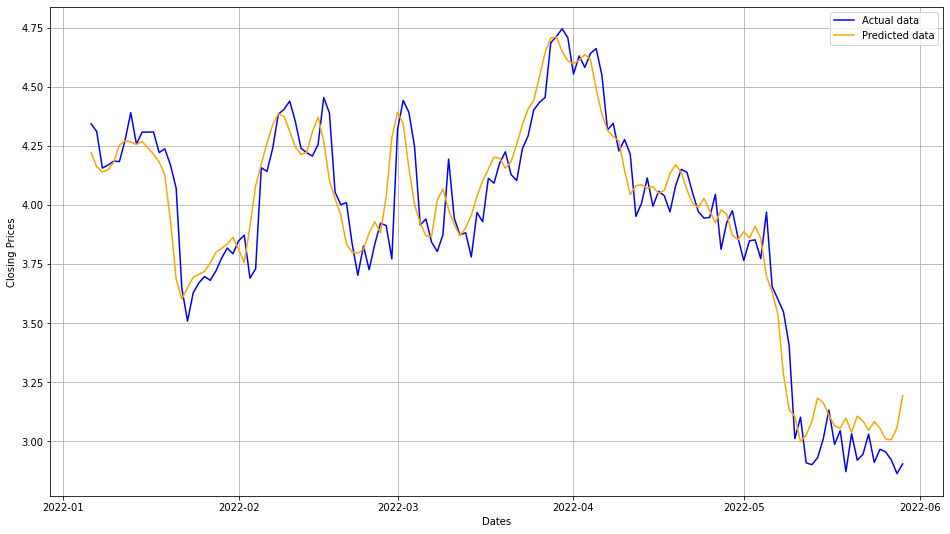

In [28]:
plt.figure(figsize=(16, 9))
plt.grid(True)
plt.xlabel('Dates')
plt.ylabel('Closing Prices')
plt.plot(df_lstm['Actual'], 'blue', label='Actual data')
plt.plot(df_lstm['LR_LSTM'], 'orange', label='Predicted data')
plt.legend()

## Đánh giá mô hình

In [29]:
from sklearn.metrics import r2_score
mae = mean_absolute_error(df_lstm.Actual, df_lstm.LR_LSTM)
mape = mean_absolute_percentage_error(df_lstm.Actual, df_lstm.LR_LSTM)
mse = mean_squared_error(df_lstm.Actual, df_lstm.LR_LSTM)
rmse = np.sqrt(mse)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape * 100:.2f}%")
print(f"MSE: {mse:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R2: {r2:.2f}")

MAE: 0.10
MAPE: 2.61%
MSE: 0.02
RMSE: 0.13
R2: -38.47


## Lấy 3 ngày cuối ra để dự báo

In [30]:
forecast = df_lstm['Error'].tail(3)
forecast

Date
2022-05-27   -4.544397
2022-05-28   -4.610980
2022-05-29   -4.579474
Name: Error, dtype: float64

## Đưa về ma trận

In [31]:
dataX = []
for i in range(len(forecast)):
    a=forecast[i]
    dataX.append(a)
dataX = np.array(dataX).reshape(1,-1,1)
dataX

array([[[-4.54439682],
        [-4.61098042],
        [-4.57947403]]])

In [32]:
y_forecast= model.predict(dataX).reshape(1,)
y_forecast

array([-4.458634], dtype=float32)

## So sánh kết quả dự đoán với giá trị thực

In [33]:
y_LR = df_pred.copy()
y_LR = y_LR.tail(4).head(1)
y_LR

,Actual,Pred,Error
Date,,,
2022-05-29,2.90271,7.482184,-4.579474


In [34]:
y_LR['Final_LSTM'] = y_LR.Pred + y_forecast
y_LR

,Actual,Pred,Error,Final_LSTM
Date,,,,
2022-05-29,2.90271,7.482184,-4.579474,3.02355


## Ghi ra file csv

In [35]:
df.to_csv("processed_data.csv")
df_scaled.to_csv("scaled_data.csv")
df_pred.to_csv("LR-PRED.csv")
df_lstm.to_csv("LSTM_PRED.csv")
y_LR.to_csv("Forecast.csv")